# <h1 align=center> **ETL - OHLCV** </h1>
## <h1 align=center> (Extract, Transform, Load) </h1>

Para el desarrollo de la primera fase de este proyecto, realizaré la aplicación del proceso ETL, el cuál básicamente consiste en `“Extraer”` los datos crudos desde su origen (Source), `“Transformarlos”` según nuestras necesidades de analítica o la estructura que deseamos y `“Cargarlos”` a una base de datos orientada a procesos analíticos (Target).

Los datos `OHLCV` son la base para la generación de gráficos de velas.

Las siglas `OHLCV`, del inglés **O**pen - **H**igh - **L**ow - **C**lose - **V**olume (_`Apertura, Máximo, Mínimo, Cierre y Volumen`_), representan la siguiente información de trading para cada periodo (para efectos de este proyecto se toma como periodicidad 24H):

+ **Open:** El primer precio negociado.
+ **Haigh:** El precio negociado más alto.
+ **Low:** El precio negociado más bajo.
+ **Close:** El último precio negociado para el periodo consultado.
+ **Volume:** El volumen total negociado en todas las operaciones.

[Title](../Imagenes/OHLC_chart.avif)

Como fase previa a la aplicación del ETL, se realizará la importación de librerías que serán de utilidad en el desarrollo del proceso, las cuales son:

In [2]:
from pycoingecko import CoinGeckoAPI
import json
import requests
import os
import pandas as pd
import datetime
import time
import ccxt
import locale

# <h1 align=left>**`Extract: OHLCV`**</h1>

Teniendo en cuenta que la información se va a descargar de la API de la plataforma CoinGecko o de otras plataformas que permitan recopilar datos de manera gratuita, en este punto se extrae información de las funciones de la API, se almacenan en `DataFrames` de la librería de `Pandas` y posteriormente se crean `Datasets` extructurados en archivos `.csv`.

**1.** Considerando la documentación del proveedor donde manifiesta que para las API públicas la granulidad de los datos es automática, es decir que no se puede cambiar, y para estas no hay intérvalo diario; se crea un DataFrame de prueba con los datos de la API de CoinGecko utilizando la función _`cg.get_coin_ohlc_by_id`_ para validar la calidad de los datos.

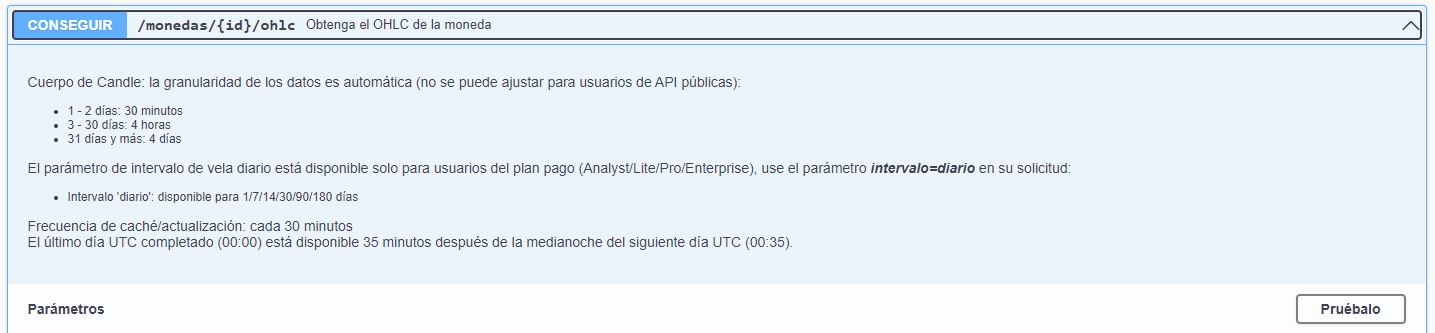

In [3]:
cg = CoinGeckoAPI()
coin_id = 'bitcoin'
vs_currency = 'usd'
days = 10
ohlc_data = []

for day in range(days):
    coin_ohlc = cg.get_coin_ohlc_by_id(
        id=coin_id,
        vs_currency=vs_currency,
        days=1,
    )
    if len(coin_ohlc) > 0:
        timestamp = pd.to_datetime(coin_ohlc[0][0], unit='ms')
        open_price = coin_ohlc[0][1]
        high_price = coin_ohlc[0][2]
        low_price = coin_ohlc[0][3]
        close_price = coin_ohlc[0][4]
        
        ohlc_data.append([timestamp, open_price, high_price, low_price, close_price])
    coin_id = 'bitcoin'
    coin_ohlc = cg.get_coin_ohlc_by_id(
        id=coin_id,
        vs_currency=vs_currency,
        days=1,
    )
ohlc_df = pd.DataFrame(ohlc_data, columns=['Time', 'Open', 'High', 'Low', 'Close'])

**2.** Se consulta el DataFrame generado para revisar los datos obtenidos.

In [4]:
ohlc_df

,Time,Open,High,Low,Close
0,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
1,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
2,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
3,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
4,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
5,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
6,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
7,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
8,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0
9,2023-08-24 05:00:00,26422.0,26457.0,26422.0,26453.0


Tal como lo menciona la documentación del proveedor, no es posible la utilización de esta API en la versión pública, por lo tanto se opta por la utilización de otra fuente de información que complemente los datos y permita realizar mayores y mejores análisis.

**3.** Para esta segunda consulta se determina utilizar la API pública de la empresa de BlockChains **`Binance`** esto por su reconocimiento y popularidad al momento de consultar en la web sobre empresas dedicadas a este mercado.

**4.** Crear DataFrame con los datos de las Criptomonedas que se comercializan en _`Binance`_.

+ **a.** Obtener el listado de criptomonedas en Binance.
+ **b.** Crear una lista de diccionarios con los datos.
+ **c.** Crear un DataFrame a partir de la lista de diccionarios.
+ **d.** Imprimir el DataFrame.

In [8]:
def get_binance_markets():
    binance = ccxt.binance()
    markets = binance.load_markets()
    return markets

# a.
crypto_markets = get_binance_markets()

# b.
data_list = []
for symbol, market_data in crypto_markets.items():
    data_list.append({
        'Símbolo': symbol,
        'Base': market_data['base'],
        'Quote': market_data['quote']
    })

# c.
df = pd.DataFrame(data_list)

# d.
df

,Símbolo,Base,Quote
0,ETH/BTC,ETH,BTC
1,LTC/BTC,LTC,BTC
2,BNB/BTC,BNB,BTC
3,NEO/BTC,NEO,BTC
4,QTUM/ETH,QTUM,ETH
...,...,...,...
2589,BCH/USD:BCH-231229,BCH,USD
2590,DOT/USD:DOT-231229,DOT,USD
2591,XRP/USD:XRP-231229,XRP,USD
2592,LTC/USD:LTC-231229,LTC,USD


**5.** Dado que la biblioteca `ccxt` puede variar en cuanto a qué campos están presentes en los datos del ticker, respecto de los datos que se venían manejando con CoinGecko, se consulta los campos disponibles para un ticker específico utilizando _`print(ticker_data)`_ y analizando qué campos son realmente proporcionados por Binance y cuáles son útiles para la necesidad de datos para el proyecto. 

In [ ]:
def get_binance_markets():
    binance = ccxt.binance()
    markets = binance.load_markets()
    return markets
crypto_markets = get_binance_markets()

for symbol, market_data in crypto_markets.items():
    print(f"Símbolo: {symbol}, Base: {market_data['base']}, Quote: {market_data['quote']}")
    ticker_data = market_data  # Por ejemplo, podrías asignar market_data a ticker_data
    
    print(ticker_data)

Debido al tamaño de la información que arroja el **_print_** se realizaó el proceso de `"Clear Cell Outputs"`.

**6.** Una vez analizados los datos de `Binance` se procede a escoger los símbolos equivalentes a las monedas que se viene trabajando en el proyecto como Top 10.

Es importante tener en cuenta que no se encontró en `Binance` registro histórico equivalente para la criptomoneda **_`'tether'`_** en dólares, por tanto solo se puede realizar consultas para 9 de las Criptomonedas Top del proyecto.

+ **a.** Agregar la columna 'symbol'.
+ **b.** Combinar los DataFrames en uno.
+ **c.** Lista de símbolos de las criptomonedas en Binance.
+ **d.** Obtener datos históricos
+ **e.** Imprimir los primeros registros de todas las criptomonedas combinadas en un DataFrame.
+ **f.** Dimensiones del DataFrame.

In [14]:
def fetch_binance_historical_data(symbols, timeframe='1d', limit=1000000):
    binance = ccxt.binance()
    
    all_data = []
    
    for symbol in symbols:
        ohlcv = binance.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        # a.
        df['symbol'] = symbol
        df.set_index('timestamp', inplace=True)
        all_data.append(df)
    # b.
    return pd.concat(all_data) 

# c.
symbols = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT', 'XRP/USDT', 'USDC/USDT', 'BETH/USDT', 'ADA/USDT', 'DOGE/USDT', 'SOL/USDT']

# d.
historical_data = fetch_binance_historical_data(symbols)

# e.
historical_data

,open,high,low,close,volume,symbol
timestamp,,,,,,
2020-11-29,17719.84,18360.05,17517.00,18184.99,5.532902e+04,BTC/USDT
2020-11-30,18185.00,19863.16,18184.99,19695.87,1.154635e+05,BTC/USDT
2020-12-01,19695.87,19888.00,18001.12,18764.96,1.276988e+05,BTC/USDT
2020-12-02,18764.96,19342.00,18330.00,19204.09,7.591101e+04,BTC/USDT
2020-12-03,19204.08,19598.00,18867.20,19421.90,6.668939e+04,BTC/USDT
...,...,...,...,...,...,...
2023-08-21,21.78,21.79,20.30,21.20,2.646392e+06,SOL/USDT
2023-08-22,21.20,21.26,19.35,20.59,3.635901e+06,SOL/USDT
2023-08-23,20.59,21.82,20.33,21.74,3.704350e+06,SOL/USDT


# <h1 align=left>**`Transform: OHLCV`**</h1>

En este punto aplicaré algunas transformaciones al _Dataframe_ para generar un Dataset útil para el momento de realizar un buen proceso de _`Exploratory Data Analysis-EDA`_, estas reglas pueden incluir procesos como:

+ Filtrar filas por ciertas características.
+ Eliminar columnas.
+ Transformar datos.
+ Extraer datos.
+ Unir o combinar datos de distintas fuentes.
+ Entre otros.

**7.** Se consulta la información de los datos contenidos en el DataFrame.

In [15]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8176 entries, 2020-11-29 to 2023-08-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    8176 non-null   float64
 1   high    8176 non-null   float64
 2   low     8176 non-null   float64
 3   close   8176 non-null   float64
 4   volume  8176 non-null   float64
 5   symbol  8176 non-null   object 
dtypes: float64(5), object(1)
memory usage: 447.1+ KB


**8.** Redondear a 2 decimales los datos de la columna `volume`.

In [16]:
numeric_column = ['volume']
historical_data[numeric_column] = historical_data[numeric_column].round(2)
historical_data

,open,high,low,close,volume,symbol
timestamp,,,,,,
2020-11-29,17719.84,18360.05,17517.00,18184.99,55329.02,BTC/USDT
2020-11-30,18185.00,19863.16,18184.99,19695.87,115463.47,BTC/USDT
2020-12-01,19695.87,19888.00,18001.12,18764.96,127698.76,BTC/USDT
2020-12-02,18764.96,19342.00,18330.00,19204.09,75911.01,BTC/USDT
2020-12-03,19204.08,19598.00,18867.20,19421.90,66689.39,BTC/USDT
...,...,...,...,...,...,...
2023-08-21,21.78,21.79,20.30,21.20,2646392.48,SOL/USDT
2023-08-22,21.20,21.26,19.35,20.59,3635900.71,SOL/USDT
2023-08-23,20.59,21.82,20.33,21.74,3704350.50,SOL/USDT


**9.** Se reemplazan los valores de la columna `symbol` por su equivalente `id` que se viene trabajando con los DataSets descargados de _CoinGecko_.

In [17]:
condicion1 = historical_data['symbol'] == 'BTC/USDT'
nuevo_valor1 = 'bitcoin'
historical_data.loc[condicion1, 'symbol'] = nuevo_valor1

In [18]:
condicion2 = historical_data['symbol'] == 'ETH/USDT'
nuevo_valor2 = 'ethereum'
historical_data.loc[condicion2, 'symbol'] = nuevo_valor2

In [19]:
condicion3 = historical_data['symbol'] == 'BNB/USDT'
nuevo_valor3 = 'binancecoin'
historical_data.loc[condicion3, 'symbol'] = nuevo_valor3

In [20]:
condicion4 = historical_data['symbol'] == 'XRP/USDT'
nuevo_valor4 = 'ripple'
historical_data.loc[condicion4, 'symbol'] = nuevo_valor4

In [21]:
condicion5 = historical_data['symbol'] == 'USDC/USDT'
nuevo_valor5 = 'usd-coin'
historical_data.loc[condicion5, 'symbol'] = nuevo_valor5

In [22]:
condicion6 = historical_data['symbol'] == 'BETH/USDT'
nuevo_valor6 = 'staked-ether'
historical_data.loc[condicion6, 'symbol'] = nuevo_valor6

In [24]:
condicion7 = historical_data['symbol'] == 'ADA/USDT'
nuevo_valor7 = 'cardano'
historical_data.loc[condicion7, 'symbol'] = nuevo_valor7

In [23]:
condicion8 = historical_data['symbol'] == 'DOGE/USDT'
nuevo_valor8 = 'dogecoin'
historical_data.loc[condicion8, 'symbol'] = nuevo_valor8

In [25]:
condicion9 = historical_data['symbol'] == 'SOL/USDT'
nuevo_valor9 = 'solana'
historical_data.loc[condicion9, 'symbol'] = nuevo_valor9
historical_data

,open,high,low,close,volume,symbol
timestamp,,,,,,
2020-11-29,17719.84,18360.05,17517.00,18184.99,55329.02,bitcoin
2020-11-30,18185.00,19863.16,18184.99,19695.87,115463.47,bitcoin
2020-12-01,19695.87,19888.00,18001.12,18764.96,127698.76,bitcoin
2020-12-02,18764.96,19342.00,18330.00,19204.09,75911.01,bitcoin
2020-12-03,19204.08,19598.00,18867.20,19421.90,66689.39,bitcoin
...,...,...,...,...,...,...
2023-08-21,21.78,21.79,20.30,21.20,2646392.48,solana
2023-08-22,21.20,21.26,19.35,20.59,3635900.71,solana
2023-08-23,20.59,21.82,20.33,21.74,3704350.50,solana


**10.** Ordenar el DataFrame, de acuerdo con las estructuras de los de los DataFrames anteriores.

In [26]:
historical_data = historical_data.reindex(columns=['symbol', 
                                            'open',
                                            'high',
                                            'low',
                                            'close',
                                            'volume',
                                            ])
historical_data

,symbol,open,high,low,close,volume
timestamp,,,,,,
2020-11-29,bitcoin,17719.84,18360.05,17517.00,18184.99,55329.02
2020-11-30,bitcoin,18185.00,19863.16,18184.99,19695.87,115463.47
2020-12-01,bitcoin,19695.87,19888.00,18001.12,18764.96,127698.76
2020-12-02,bitcoin,18764.96,19342.00,18330.00,19204.09,75911.01
2020-12-03,bitcoin,19204.08,19598.00,18867.20,19421.90,66689.39
...,...,...,...,...,...,...
2023-08-21,solana,21.78,21.79,20.30,21.20,2646392.48
2023-08-22,solana,21.20,21.26,19.35,20.59,3635900.71
2023-08-23,solana,20.59,21.82,20.33,21.74,3704350.50


In [29]:
numeric_columns = ['open', 
                'high', 
                'low', 
                'close', 
                ]
historical_data[numeric_columns] = historical_data[numeric_columns].round(2)
historical_data

,symbol,open,high,low,close,volume
timestamp,,,,,,
2020-11-29,bitcoin,17719.84,18360.05,17517.00,18184.99,55329.02
2020-11-30,bitcoin,18185.00,19863.16,18184.99,19695.87,115463.47
2020-12-01,bitcoin,19695.87,19888.00,18001.12,18764.96,127698.76
2020-12-02,bitcoin,18764.96,19342.00,18330.00,19204.09,75911.01
2020-12-03,bitcoin,19204.08,19598.00,18867.20,19421.90,66689.39
...,...,...,...,...,...,...
2023-08-21,solana,21.78,21.79,20.30,21.20,2646392.48
2023-08-22,solana,21.20,21.26,19.35,20.59,3635900.71
2023-08-23,solana,20.59,21.82,20.33,21.74,3704350.50


# <h1 align=left>**`Load: OHLCV`**</h1>

**11.** Teniendo lista la información con los datos deseados se procede con la creación del nuevo Dataset.

In [30]:
historical_data.to_csv("..\Datasets\OHLCV_data.csv")